# 02. Neural network classification with Pytorch

## 1. Make some data and get it ready:

In [1]:
import sklearn
from sklearn.datasets import make_circles

In [2]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, 
                                      noise = 0.03, 
                                      random_state = 42)

In [3]:
len(X),len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [5]:
# Make dataframe:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], 
                                               "X2": X[:, 1], 
                                              "label": y})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


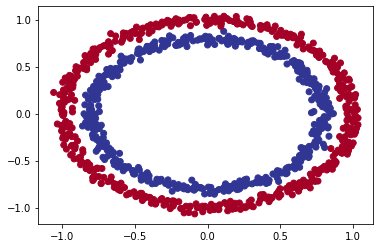

In [6]:
# Visualize:
import matplotlib.pyplot as plt
plt.scatter(x = X[:, 0], y = X[:, 1], c= y, cmap = plt.cm.RdYlBu)

Note the data we're working with is often referred to as a toy dataset but still sizeable enough.

### 1.1 Check input and output shape:

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

## 1.2 Turn data into tensors and create train& test splits

In [9]:
import torch
torch.__version__

'1.12.1+cu113'

In [10]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [11]:
# Turn data into tensors:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [12]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [13]:
# Split data into training and test sets:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [14]:
len(X_train), len(X_test)

(800, 200)

In [15]:
n_samples =  1000

## 2. Building a model

Let's build a model to classify our blue and red dots.

1. Setup device agnostic code so our code will run on an accelerator (GPU).
2. Construct a model (nn.Module)
3. Define a loss function and optimizer
4. Create a training and test loop

In [16]:
# Import Pytorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

1. Subclassess `nn.Module` (almost all models in Pytorch)
2. Create 2 `nn.Linear()` layers capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [17]:
# 1. Construct a model that subclassess nn.Module
class CircleModelV0(nn.Module):
        def __init__(self):
            super().__init__()
            # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
            self.layer_1 = nn.Linear(in_features  = 2, out_features = 8) # takes in 2 features and upscales to 5 features
            self.layer_2 = nn.Linear(in_features = 8, out_features = 1) # takes in 5 features and outputs a single feature.

            #self.two_linear_layers = nn.Sequential(nn.Linear(in_features = 2, out_features = 8),
            #                                                                            nn.Linear(in_features = 8, out_features = 1))
        
        # 3. Define a forward() method that outlines the forward pass
        def forward(self, x):
            return self.layer_2(self.layer_1(x))  # x --> layer_1  --> layer_2 --> output
            #return self.two_linear_layers(x)




# 4. Instantiate an instance of our model class and send it to the target device
m1 = CircleModelV0().to(device)
m1

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [18]:
device

'cuda'

In [19]:
next(m1.parameters()).device

device(type='cuda', index=0)

In [20]:
# Let's replicate the model above using nn.Sequential()

#m1 = nn.Sequential(nn.Linear(in_features = 2, out_features = 8),
 #                                     nn.Linear(in_features = 8, out_features = 1)).to(device)

#m1

In [21]:
m1.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.5096, -0.6076],
                      [-0.6137, -0.1566],
                      [ 0.1670, -0.3213],
                      [ 0.6524,  0.1526],
                      [-0.6438, -0.1854],
                      [-0.5292, -0.0384],
                      [ 0.6840,  0.2252],
                      [-0.0726,  0.3365]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.2093,  0.3779,  0.2364,  0.5822,  0.1195, -0.5542,  0.1144,  0.5329],
                     device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.0270, -0.0588, -0.0269, -0.0421, -0.1582,  0.2827,  0.3308,  0.2380]],
                     device='cuda:0')),
             ('layer_2.bias', tensor([0.1263], device='cuda:0'))])

In [22]:
# Change data type
# X_test = torch.from_numpy(X_test)

# Make predictions:
with torch.inference_mode():
    untrained_preds = m1(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[0.],
        [0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [0.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## 2.1 Setup loss function and optimizer:

Which loss function or optimizer should we use? -> Problem specific. 

- Regresison: MAE or MSE
- Classification: Binary cross entropy or categorical cross entropy.

The loss function measures how *wrong* your models predictions are.

And for optimizer, two most common opt are SGD and Adam.

* For the loss function, we are going to use `torch.nn.BECWithLogitsLoss()`

In [23]:
# Setup the loss function:
# loss_fn = nn.BCELoss() # BCELoss requires inputs 
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = m1.parameters(),
                                                          lr = 0.1)

In [24]:
# Calculate the accuracy:

def accuracy_fn(y_true, y_pred):
      correct =  torch.eq(y_true, y_pred).sum().item()
      acc = (correct/len(y_pred))*100
      return acc

## 3. Train model

To train our model, we're going to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward
5. Optimizer step

### 3.1 Going from raw logits --> prediction probabilities --> prediction labels

Our model outputs are going to be raw **logits**. 

We conver logits into prediction probability by passing them to activation functions (sigmoid for bin class, softmax for multiclass classification).

Then we can convert our model's prediction probabilities to prediction labels by either rounding them.

In [25]:
# View the first 5 outputs of the forward pass on the test data:
m1.eval()

with torch.inference_mode():
      y_logits = m1(X_test.to(device))[:5]
y_logits

tensor([[ 0.1483],
        [ 0.2632],
        [-0.1018],
        [ 0.2189],
        [-0.0204]], device='cuda:0')

In [26]:
# Use the sigmoid function on our model logits

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5370],
        [0.5654],
        [0.4746],
        [0.5545],
        [0.4949]], device='cuda:0')

In [27]:
# Find the predicted labels:
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(m1(X_test.to(device))))

In [28]:
# Check for quality
print(torch.eq(y_pred_labels[:5].squeeze(), y_preds.squeeze()))

tensor([True, True, True, True, True], device='cuda:0')


In [29]:
y_preds.squeeze()

tensor([1., 1., 0., 1., 0.], device='cuda:0')

### 3.2 Building a training and testing loop:

In [30]:
device

'cuda'

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs:
epochs = 100

# Put data to target device:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    # training
    m1.train()

    # 1. Forward pass:
    y_logits = m1(X_train).squeeze()
    y_pred  = torch.round(torch.sigmoid(y_logits)) # turn logits --> pred probs --> pred labels

    # 2. Calculate loss/accuracy
    #loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCELoss
    loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss
    acc =  accuracy_fn(y_true = y_train, y_pred = y_pred)   

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (back prop)
    loss.backward()

    # 5. Optimizer step 
    optimizer.step()

    # Testing
    m1.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = m1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))   

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true= y_test, y_pred = test_pred)

    # print out what's happenin'
    if epoch % 10 == 0:
      print(f"Epoch: {epoch}    |   Loss:   {loss:.5f}, Acc:    {acc:.2f}%    | Test loss:    {test_loss:.5f}     , Test acc:   {test_acc:.2f}  ")

Epoch: 0    |   Loss:   0.69542, Acc:    52.38%    | Test loss:    0.70293     , Test acc:   47.00  
Epoch: 10    |   Loss:   0.69438, Acc:    52.12%    | Test loss:    0.70088     , Test acc:   45.00  
Epoch: 20    |   Loss:   0.69392, Acc:    51.50%    | Test loss:    0.69967     , Test acc:   46.00  
Epoch: 30    |   Loss:   0.69367, Acc:    51.38%    | Test loss:    0.69885     , Test acc:   45.50  
Epoch: 40    |   Loss:   0.69351, Acc:    51.38%    | Test loss:    0.69824     , Test acc:   45.50  
Epoch: 50    |   Loss:   0.69340, Acc:    51.38%    | Test loss:    0.69776     , Test acc:   45.50  
Epoch: 60    |   Loss:   0.69331, Acc:    51.25%    | Test loss:    0.69737     , Test acc:   46.00  
Epoch: 70    |   Loss:   0.69325, Acc:    51.25%    | Test loss:    0.69705     , Test acc:   46.00  
Epoch: 80    |   Loss:   0.69320, Acc:    51.62%    | Test loss:    0.69678     , Test acc:   46.00  
Epoch: 90    |   Loss:   0.69316, Acc:    51.25%    | Test loss:    0.69654     , T

## 4. Make predictions and evaluate the model

It looks our model did not learn anything.

To do so, we're going to import a function called ``plot_`

In [32]:
import requests
from pathlib import Path

# Download helpler function from Learn Pytorch repo
if Path("helper_functions.py").is_file():
      print("helper_functions.py already exists")
else:
      print("Download helper_functions.py")
      request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
      with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


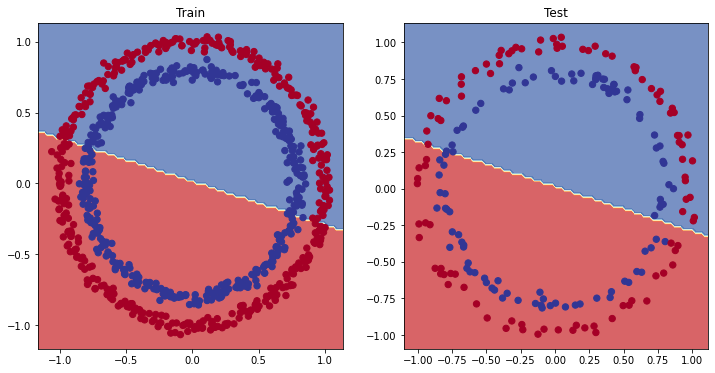

In [33]:
# Plot decision boundary of the model:

plt.figure(figsize =  (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(m1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(m1, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers
* Add more hidden units 
* Fit for longer
* Change activation function
* Change the learning rate
* Change the loss function

These options are all from a model's perspective.

Let's improve: add hiden units, add layers, add more epochs.

In [34]:
class CircleModelV1(nn.Module):
      def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features  =2, out_features  =10)
        self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
        self.layer_3 = nn.Linear(in_features = 10, out_features =1)

      def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x)))

m1 = CircleModelV1().to(device)
m1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [35]:
m1.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0

In [36]:
# Create a loss function:
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer:
optimizer = torch.optim.SGD(params = m1.parameters(),
                                                          lr = 0.1)

In [37]:
# Write a training and evaluation loop:

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device:
X_train, y_train  = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
                                        

for epoch in range(epochs):
  ### Training:
  m1.train()

  # 1. Forward pass
  y_logits = m1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits --> pred probs --> prediction

  # 2. calculate loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train, y_pred = y_pred)

  # 3. Optimzer zero grad
  optimizer.zero_grad()

  # 4. Optimzer step (grad descent):
  optimizer.step()

  #### Testing
  m1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = m1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc =  accuracy_fn(y_true = y_test, y_pred = test_pred)

    # print out what's happeníng''
    if epoch % 100 ==0:
      print(f"Epoch: {epoch}    |   Loss:   {loss:.5f}, Acc:    {acc:.2f}%    | Test loss:    {test_loss:.5f}     , Test acc:   {test_acc:.2f}  ")

Epoch: 0    |   Loss:   0.69396, Acc:    50.88%    | Test loss:    0.69261     , Test acc:   51.00  
Epoch: 100    |   Loss:   0.69396, Acc:    50.88%    | Test loss:    0.69261     , Test acc:   51.00  
Epoch: 200    |   Loss:   0.69396, Acc:    50.88%    | Test loss:    0.69261     , Test acc:   51.00  
Epoch: 300    |   Loss:   0.69396, Acc:    50.88%    | Test loss:    0.69261     , Test acc:   51.00  
Epoch: 400    |   Loss:   0.69396, Acc:    50.88%    | Test loss:    0.69261     , Test acc:   51.00  
Epoch: 500    |   Loss:   0.69396, Acc:    50.88%    | Test loss:    0.69261     , Test acc:   51.00  
Epoch: 600    |   Loss:   0.69396, Acc:    50.88%    | Test loss:    0.69261     , Test acc:   51.00  
Epoch: 700    |   Loss:   0.69396, Acc:    50.88%    | Test loss:    0.69261     , Test acc:   51.00  
Epoch: 800    |   Loss:   0.69396, Acc:    50.88%    | Test loss:    0.69261     , Test acc:   51.00  
Epoch: 900    |   Loss:   0.69396, Acc:    50.88%    | Test loss:    0.6926

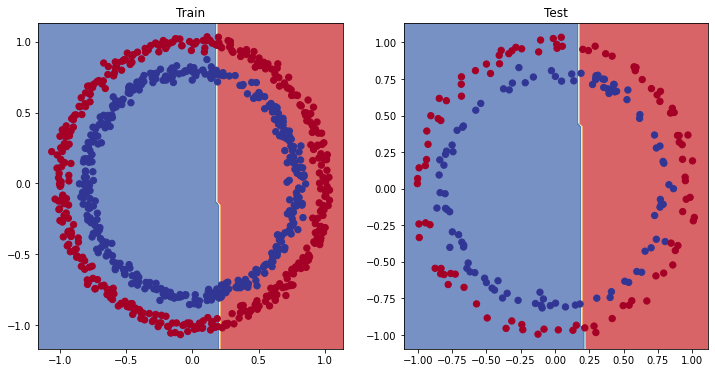

In [38]:
# Plot the decision boundary:
plt.figure(figsize =  (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(m1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(m1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line:

Test out a smaller problem.

In [39]:
# Create some data:
weight = 0.7
bias = 0.3
start = 0
end  = 1
step = 0.01

# Data
X_reg = torch.arange(start, end, step).unsqueeze(dim = 1)
y_reg = weight*X_reg + bias

# Check the data:
print(len(X_reg))
X_reg[:5], y[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]), tensor([1., 1., 1., 1., 0.]))

In [40]:
# train & test split
tsp = int(0.8*len(X_reg))
X_train_reg, y_train_reg  = X_reg[:tsp], y_reg[:tsp]
X_test_reg , y_test_reg = X_reg[tsp:], y_reg[tsp:]

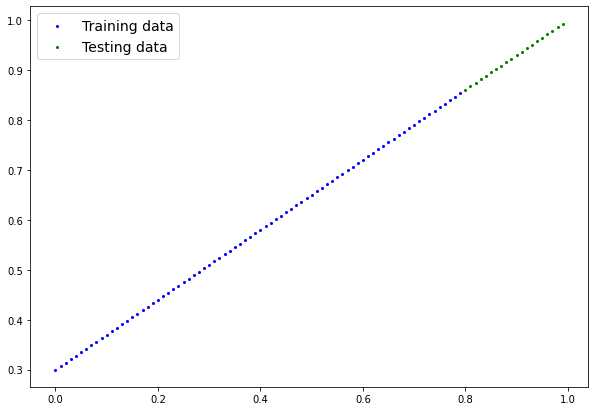

In [41]:
plot_predictions(train_data = X_train_reg,
                                 train_labels = y_train_reg,
                                test_data = X_test_reg,
                                test_labels  = y_test_reg)

### 5.2 Adjust `m1` to fit a straight line

In [42]:
# Same architecture as m1, but using nn.Sequential:

m2 = nn.Sequential(
    nn.Linear(in_features = 1, out_features = 10),
    nn.Linear(in_features = 10, out_features = 10),
    nn.Linear(in_features = 10, out_features = 1)
).to(device)

m2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [43]:
# Loss and optimizer:

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(m2.parameters(), lr= 0.1)

In [46]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# put the data on the target device:
X_train_reg, y_train_reg = X_train_reg.to(device), y_train_reg.to(device)
X_test_reg, y_test_reg = X_test_reg.to(device), y_test_reg.to(device)

# Training
for epoch in range(epochs):
  y_pred = m2(X_train_reg)
  loss = loss_fn(y_pred, y_train_reg)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing:
  m2.eval()
  with torch.inference_mode():
    test_pred = m2(X_test_reg)
    test_loss  = loss_fn(test_pred, y_test_reg)

# Print our what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch}    |   Loss:   {loss:.5f}    | Test loss:    {test_loss:.5f}  ")
                                                    

Epoch: 0    |   Loss:   0.06466    | Test loss:    0.02598  
Epoch: 100    |   Loss:   0.05518    | Test loss:    0.00679  
Epoch: 200    |   Loss:   0.07117    | Test loss:    0.01923  
Epoch: 300    |   Loss:   0.05287    | Test loss:    0.00530  
Epoch: 400    |   Loss:   0.07116    | Test loss:    0.00436  
Epoch: 500    |   Loss:   0.04987    | Test loss:    0.00735  
Epoch: 600    |   Loss:   0.04989    | Test loss:    0.00927  
Epoch: 700    |   Loss:   0.05846    | Test loss:    0.00987  
Epoch: 800    |   Loss:   0.05230    | Test loss:    0.00454  
Epoch: 900    |   Loss:   0.04446    | Test loss:    0.02777  


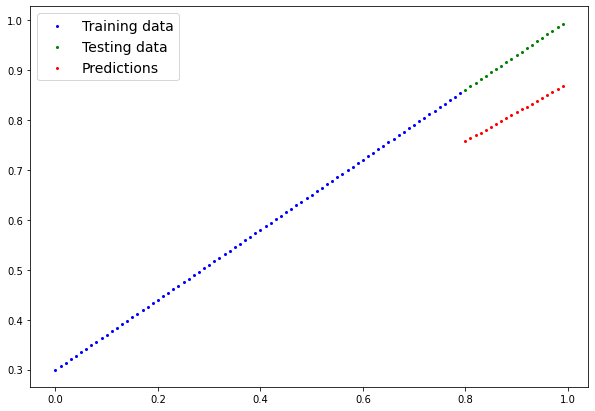

In [48]:
# Turn on evaluation mode
m2.eval()

# Make predictions (inference):
with torch.inference_mode():
    y_preds = m2(X_test_reg)

# Plot data & predictions
plot_predictions(train_data=X_train_reg.cpu(), 
                 train_labels=y_train_reg.cpu(),
                 test_data=X_test_reg.cpu(),
                 test_labels=y_test_reg.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: non-linearity

'What patterns could you draw with an infinite amount of straight & non-straight lines?'

### 6.1 Recreating non-linear data (red & blue circles)

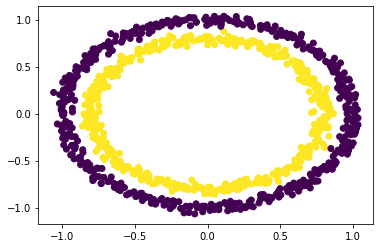

In [49]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise = 0.03, random_state = 42)

plt.scatter(X[:, 0], X[:, 1], c = y)

In [50]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.2, random_state = 42)

In [51]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]), tensor([1., 0., 0., 0., 1.]))

### 6.2 Building model with non-linearity

* Linear: straight, non-linear: non-straight line.

In [52]:
# Build a model with non-linear activation functions:

from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
      super().__init__()
      self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
      self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
      self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
      self.relu = nn.ReLU()     # ReLU is a non-linear activation function
      
    def forward(self, x):
      # Where should we put our non-linear activation functions:
      return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_3(x)))))

m3 = CircleModelV2().to(device)
m3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
m3